<a href="https://colab.research.google.com/github/deekshitha16/pneumonia-detection-on-x_ray-image/blob/master/Pnemonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import os, shutil
import cv2
import glob
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [0]:
train_path = '/content/drive/My Drive/chest_xray/chest_xray/train'
valid_path = '/content/drive/My Drive/chest_xray/chest_xray/val'
test_path  = '/content/drive/My Drive/chest_xray/chest_xray/test'

In [0]:
os.listdir(train_path)


['PNEUMONIA', 'NORMAL', '.DS_Store', 'pneumonia_blanced']

In [0]:
#os.rmdir('/content/drive/My Drive/chest_xray/chest_xray/train/new')
#os.rmdir('/content/drive/My Drive/chest_xray/chest_xray/train/uneffected')
shutil.rmtree('/content/drive/My Drive/chest_xray/chest_xray/train/new_phneumonia', ignore_errors=True)

In [0]:
train_path = Path('/content/drive/My Drive/chest_xray/chest_xray/train')

In [0]:
normal_cases_dir = train_path/'NORMAL'
phneumonia_cases_dir = train_path/'PNEUMONIA'

In [0]:
normal_cases = normal_cases_dir.glob('*.jpeg')
phneumonia_cases = phneumonia_cases_dir.glob('*.jpeg')

In [0]:
train_data = []

for img in normal_cases:
  train_data.append((img, 0))

for img in phneumonia_cases:
  train_data.append((img, 1))  


In [0]:
# creating a  new dataframe for image dataset using pandas library

train_data = pd.DataFrame(train_data, columns=['image','label'])

In [0]:
# The dataframe with label-0 as 'Normal' and label-1 as 'Phneumonia'

train_data.head()

,image,label
0,/content/drive/My Drive/chest_xray/chest_xray/...,0
1,/content/drive/My Drive/chest_xray/chest_xray/...,0
2,/content/drive/My Drive/chest_xray/chest_xray/...,0
3,/content/drive/My Drive/chest_xray/chest_xray/...,0
4,/content/drive/My Drive/chest_xray/chest_xray/...,0


In [0]:

train_data['label'].value_counts()

1    2534
0    1341
Name: label, dtype: int64

In [0]:
seed =123
np.random.seed(seed)

In [0]:
# lets shuffle the dataset 

train_data = train_data.sample(frac=1.).reset_index(drop=True)


In [0]:
train_data.head()


,image,label
0,/content/drive/My Drive/chest_xray/chest_xray/...,0
1,/content/drive/My Drive/chest_xray/chest_xray/...,0
2,/content/drive/My Drive/chest_xray/chest_xray/...,0
3,/content/drive/My Drive/chest_xray/chest_xray/...,0
4,/content/drive/My Drive/chest_xray/chest_xray/...,0


In [0]:
train_data['label'].value_counts()

1    2534
0    1341
Name: label, dtype: int64

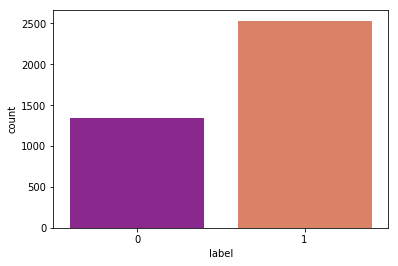

In [0]:
# from countplot we can see that there is unequal distribution of dataset

sns.countplot(train_data['label'], palette='plasma')

In [0]:
src = '/content/drive/My Drive/chest_xray/chest_xray/train/PNEUMONIA'
dst = '/content/drive/My Drive/chest_xray/chest_xray/train/pneumonia_blanced'

In [0]:
'''
for file in os.listdir('/content/drive/My Drive/chest_xray/chest_xray/train/PNEUMONIA')[:1341]:
  src_path = os.path.join(src,file)
  dst_path = os.path.join(dst ,file)
  os.rename(src_path, dst_path)
'''


"\nfor file in os.listdir('/content/drive/My Drive/chest_xray/chest_xray/train/PNEUMONIA')[:1341]:\n  src_path = os.path.join(src,file)\n  dst_path = os.path.join(dst ,file)\n  os.rename(src_path, dst_path)\n"

In [0]:
# moving the file from one directory to another
'''
for f in os.listdir('/content/drive/My Drive/chest_xray/chest_xray/train/PNEUMONIA')[:1341]:
  src_name = os.path.join(src, f)
  shutil.copy(src_name,'/content/drive/My Drive/chest_xray/chest_xray/train/pneumonia_blanced/.jpeg')
  
'''  




In [0]:
normal_dir = train_path/'NORMAL'
phenumonia_dir = train_path/'pneumonia_blanced'

normal_case = normal_dir.glob('*.jpeg')
phenumonia_case = phenumonia_dir.glob('*.jpeg')

In [0]:
new_train_data =[]

for img in normal_case:
  new_train_data.append((img,0))

for img in phenumonia_case:
  new_train_data.append((img,1))

In [0]:
df = pd.DataFrame(new_train_data, columns=['image','label'], dtype=str)
df = df.reindex(np.random.permutation(df.index))

In [0]:
df.head()

,image,label
2615,/content/drive/My Drive/chest_xray/chest_xray/...,1
1690,/content/drive/My Drive/chest_xray/chest_xray/...,1
65,/content/drive/My Drive/chest_xray/chest_xray/...,0
2045,/content/drive/My Drive/chest_xray/chest_xray/...,1
2388,/content/drive/My Drive/chest_xray/chest_xray/...,1


In [0]:
df['label'].value_counts()

1    1342
0    1341
Name: label, dtype: int64

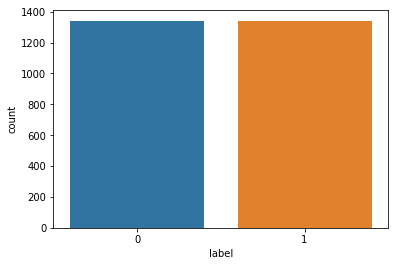

In [0]:
sns.countplot(df['label'])

In [0]:
df.dtypes

image    object
label    object
dtype: object

In [0]:
os.listdir(train_path)

['PNEUMONIA', 'NORMAL', '.DS_Store', 'pneumonia_blanced']

In [0]:
# lets build the model
# here i will be using vgg16 pretrainded model, u can use any other model of your choice
# lets import vgg16 library and weights used here is imagenet weights

image_size = [224,224]

vgg = VGG16(input_shape = image_size+[3], weights = 'imagenet', include_top = False)

In [0]:
# here i am not training the model again, using  the old pretrained model weights 
for layer in vgg.layers:
  layer.trainable = False

In [0]:
# now lets create a dense layer for predicting output

x = Flatten()(vgg.output)

x = Dense(128, activation='relu', name='fc1')(x)
x = Dropout(rate = 0.2, name='dropout1')(x)
prediction = Dense(2, activation='softmax', name='output_layer')(x)


model = Model(inputs = vgg.input , outputs = prediction)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [0]:
# path for validation and testing data

valid_path = '/content/drive/My Drive/chest_xray/chest_xray/val'
test_path  = '/content/drive/My Drive/chest_xray/chest_xray/test'

In [0]:
os.listdir(test_path)

['PNEUMONIA', 'NORMAL', '.DS_Store']

In [0]:
# for training set i will use dataframe which as equal distribution of categories

data_gen = ImageDataGenerator(rescale=1./255)

training_set = data_gen.flow_from_dataframe(dataframe = df,
                                x_col = 'image',
                                y_col = 'label',
                                target_size=(224,224),
                                class_mode='categorical',
                                batch_size=128,
                                shuffle = True,
                                seed = 1)

Found 2683 validated image filenames belonging to 2 classes.


In [0]:
test_set = data_gen.flow_from_directory(directory = test_path,
                                              target_size = (224,224),
                                              batch_size = 64,
                                              color_mode = 'rgb',
                                              class_mode = 'categorical')                                
                                        
                                        
                                            

Found 624 images belonging to 2 classes.


In [0]:
# now fit the model 

# using EarlyStopping for preventing overfitting and stop the epochs if there is \
# no progress in the validation accuracy, will check after every 3 epochs, by setting patience=3    


''''moniter = EarlyStopping(monitor = 'val_loss',
                        min_delta = 1e-3,
                        patience = 2,
                        restore_best_weights = True,
                        verbose = 1,
                        mode = 'min')                        

hist = model.fit_generator(generator = training_set,
                    steps_per_epoch = len(training_set),
                    validation_data = test_set,
                    validation_steps = len(test_set),
                    epochs = 10,
                    callbacks = [moniter])''''

Epoch 1/10


In [0]:
# # lets save the training model performance in h5 file
# import tensorflow as tf
# from keras.models import load_model

# model.save('lung_disease_vgg16.h5')


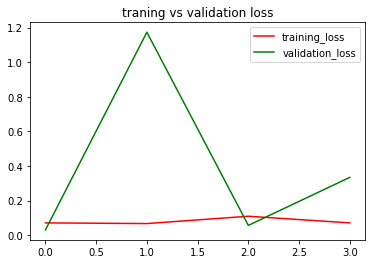

<Figure size 432x288 with 0 Axes>

In [0]:
# lets plot the graph for accuracy and loss

# plot for training and validation loss

'''plt.figure(fi) 
plt.plot(hist.history['loss'], label = 'training_loss', color = 'red')
plt.plot(hist.history['val_loss'] , label = 'validation_loss',  color = 'green')
plt.legend()
plt.title('traning vs validation loss')
plt.show()
plt.savefig('tran_val_loss')'''

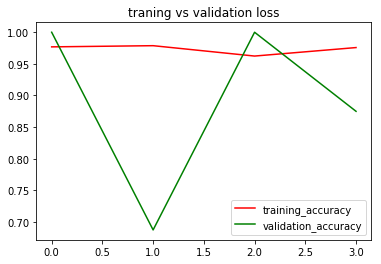

<Figure size 432x288 with 0 Axes>

In [0]:
# # plot for training and validation accuracy

# plt.plot(hist.history['acc'], label = 'training_accuracy', color = 'red')
# plt.plot(hist.history['val_acc'] , label = 'validation_accuracy', color = 'green')
# plt.legend()
# plt.title('traning vs validation loss')
# plt.show()
# plt.savefig('tran_val_loss')


In [0]:

# plt.plot(hist.history['loss'], label = 'training_loss', color = 'red')
# plt.plot(hist.history['val_loss'] , label = 'validation_loss',  color = 'green')
# plt.legend()
# plt.title('traning vs validation loss')
# plt.show()
# plt.savefig('tran_val_loss')

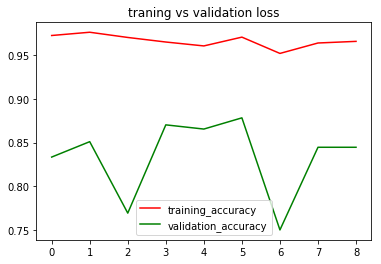

<Figure size 432x288 with 0 Axes>

In [0]:
# plt.plot(hist.history['acc'], label = 'training_accuracy', color = 'red')
# plt.plot(hist.history['val_acc'] , label = 'validation_accuracy', color = 'green')
# plt.legend()
# plt.title('traning vs validation loss')
# plt.show()
# plt.savefig('tran_val_loss')

In [0]:
#  # now lets predict the model on validation set
# validation_set = data_gen.flow_from_directory(directory = valid_path,
#                                               target_size = (224,224),
#                                               batch_size = 16,
#                                               class_mode = 'categorical')                      

FileNotFoundError: ignored

In [0]:

# y_pred = model.predict_generator(generator = validation_set,
#                                  steps = 1,
#                                  verbose = 0)

In [0]:
# test_img , test_labels = next(validation_set)

NameError: ignored

In [0]:
# y_test = test_labels[:,0]


In [0]:
# y_test

NameError: ignored

In [0]:
# y_pred[:,0]

TypeError: ignored

In [0]:
# from sklearn.metrics import confusion_matrix
# import itertools



In [0]:
# cm = confusion_matrix(y_test , y_pred[:,0])

# classes = ['Phenumonia','Normal']

# def plot_confusion_matrix(y_test, y_pred, classes,
#                           normalize=False,
#                           title='confusion_matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks , classes, rotation = 45)
#     plt.yticks(tick_marks , classes)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)
#     thresh = cm.max() / 2.
#     for i , j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#             plt.text(j, i, cm[i, j] ,
#                     horizontal="center",
#                     color="white" if cm[i, j] > thresh else "black")

NameError: ignored

19.5